In [ ]:
## Classification of vegetation species in Gwydir Wetlands -- Edited by AW in Sep 2023 

# Install library
# Run these in cmd for the first time
pip install av
pip install imageio
pip install earthpy
#conda install -c conda-forge av
#conda install -c conda-forge imageio
#conda install -c conda-forge earthpy

In [4]:
# Import basic packages
import earthpy.plot as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn import svm
from imageio import imread
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score 
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap

C:\Users\wang14\AppData\Local\Temp\ipykernel_16416\1989505948.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imread('S:\Anne1\Projects\MDBA_Gwydir\classification\python\inputs\Gwydir_0517_sub1.tif') #change the root


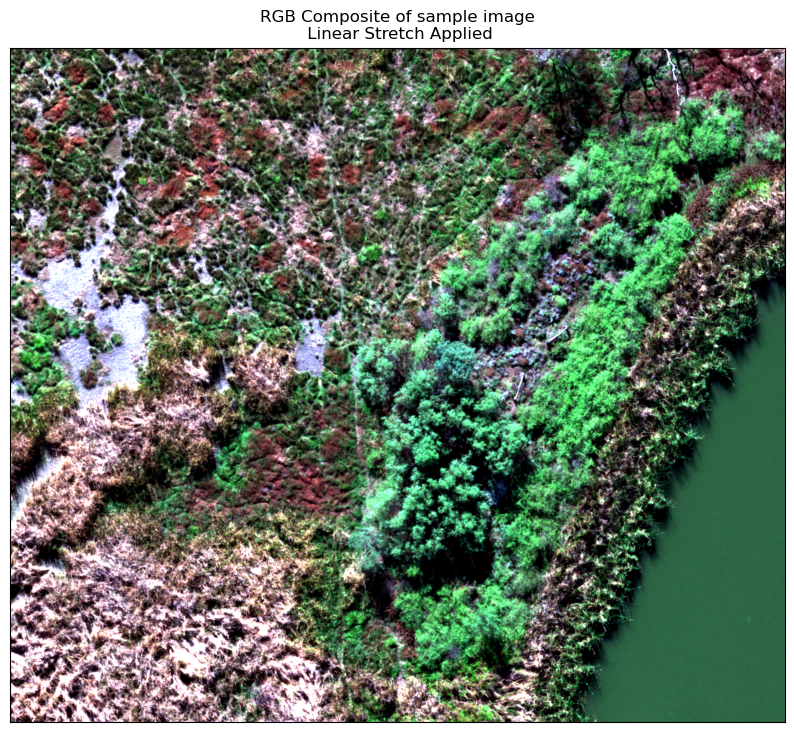

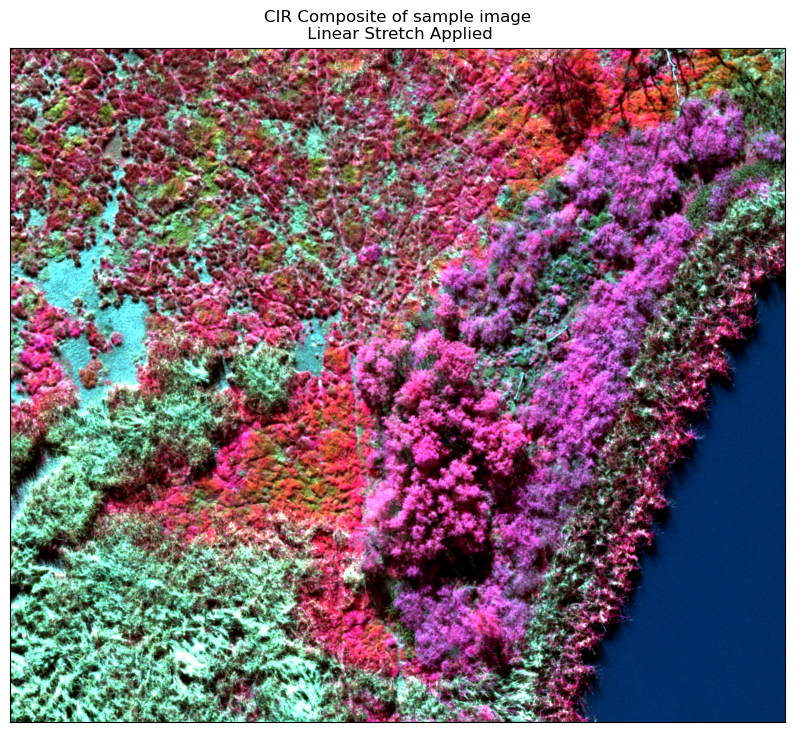

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


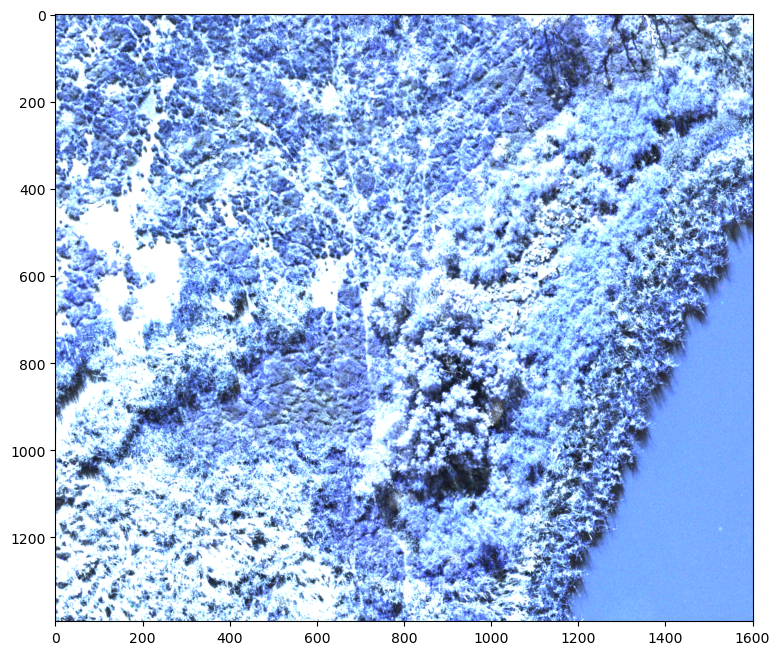

In [5]:
# Open and display image
# read the image file
im0 = imread('\MDBA_Gwydir\classification\python\inputs\Gwydir_0517_sub1.tif') #change file root

# plot RGB image
ep.plot_rgb(im0,
            rgb=[5,3,1],
            title="RGB Composite of sample image\n Linear Stretch Applied",
            stretch=True,
            str_clip=4)
plt.show()

# plot CIR image
ep.plot_rgb(im0,
            rgb=[8, 5, 3],
            title="CIR Composite of sample image\n Linear Stretch Applied",
            stretch=True,
            str_clip=4)
plt.show()

# Transpose image
im = np.transpose(im0, (1,2,0))
plt.figure(figsize = (9,9))
plt.imshow(im[:,:,0:3])

In [6]:
# Open the label image
imlabel0 = pd.read_csv('\MDBA_Gwydir\classification\python\inputs\Gwydir_0517_sub1_label3.csv', 
                       header=None, delimiter='[ \t]*,[ \t]*') #change file root

# convert dataframe to array
imlabel = pd.DataFrame(imlabel0).to_numpy()

# replace negative values to 0
imlabel[imlabel<0] = 0 

C:\Users\wang14\AppData\Local\Temp\ipykernel_16416\593095108.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imlabel0 = pd.read_csv('S:\Anne1\Projects\MDBA_Gwydir\classification\python\inputs\Gwydir_0517_sub1_label3.csv',


In [7]:
# Split the data into training and testing sets
# select non zero values
imground = im[imlabel.nonzero()]
imlabelground = imlabel[imlabel.nonzero()]

# stratified random sampling
X_train, X_test, y_train, y_test = train_test_split(imground, imlabelground, test_size=0.3, random_state=42, stratify=imlabelground)

In [ ]:
# Train data using SVM classifier with hyperparameter
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']} 
gridsvm = GridSearchCV(SVC(),param_grid,refit=True,cv = 10, n_jobs = -1,verbose = 2)

# Fit the training data
gridsvm.fit(X_train, y_train)

# Find the optimal parameters
gridsvm.best_params_
gridsvm.best_estimator_
print(gridsvm.best_estimator_)

# Make the prediction
y_pred_gridsvm = gridsvm.predict(X_test)


Fitting 10 folds for each of 64 candidates, totalling 640 fits


In [ ]:
# Assign prediction and model name for the following analysis 
model0 = gridsvm
y_pred = y_pred_gridsvm

In [16]:
# Save trained model (optional)
model_pkl = "Gwydir_vegetation_classifier_svmmodel.pkl" # Change file name
with open(model_pkl, 'wb') as file:
    pickle.dump(model0, file)

Overall Accuracy: 0.9683170856849667
Kappa: 0.9455424988253821
Classification Report:
                      precision    recall  f1-score   support

Flat_spike_rush_mix       0.88      0.88      0.88       816
      Noogoora_burr       0.35      0.10      0.16       259
               Soil       0.98      0.99      0.99       410
   Cumbungi_dry_mix       0.96      0.98      0.97      8682
   Slender_knotweed       0.99      0.98      0.99       237
              Shade       0.89      0.85      0.87        65
         Tree_bough       0.88      0.84      0.86        25
             Mimosa       1.00      1.00      1.00       220
          Waterbody       1.00      1.00      1.00      4878

           accuracy                           0.97     15592
          macro avg       0.88      0.85      0.86     15592
       weighted avg       0.96      0.97      0.96     15592

Confusion Matrix:
                      Flat_spike_rush_mix  Noogoora_burr  Soil  \
Flat_spike_rush_mix              

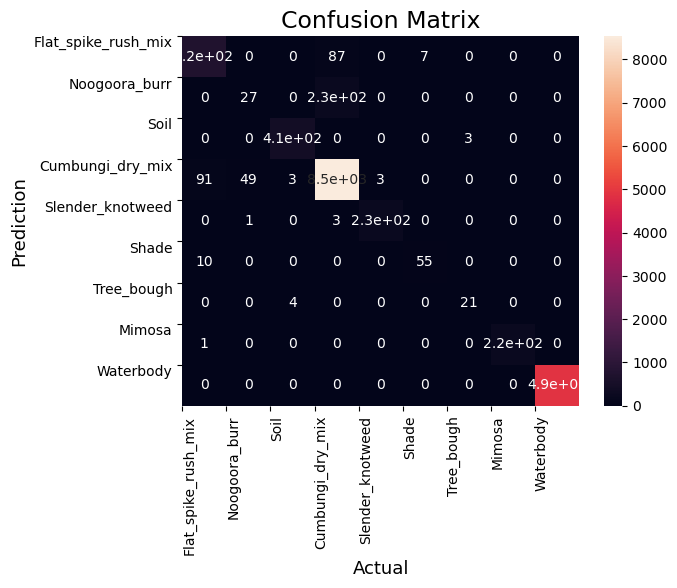

In [14]:
# Assess model performance
# Define class label
class_labels = ["Flat spike rush","Slender knotweed","Cumbungi dry","Noogoora burr","Trees","Shade","Tree bough",
               "Mimosa","Cumbungi","Soil","Tall spike rush dry","Tall spike rush","Water","Tussock rush"]
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test,y_pred)

# Compute the overall accuracy
overall_accuracy = accuracy_score(y_test,y_pred)

# Compute the kappa coefficient
kappa = cohen_kappa_score(y_test,y_pred)

# Display the overall accuracy and kappa
print('Overall Accuracy:', overall_accuracy)
print('Kappa:', kappa)
print('Classification Report:\n', classification_report(y_test,y_pred,target_names=class_labels))
# set the max columns to none
pd.set_option('display.max_columns', None)
print ('Confusion Matrix:\n',pd.DataFrame(confusion_mat, columns=class_labels, index=class_labels))

# Plot the confusion matrix in a figure
sns.heatmap(confusion_mat,annot=True)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=90, ha="left",va="top")
plt.yticks(np.arange(len(class_labels)), class_labels, rotation=0,ha="right", va="top")
plt.show()

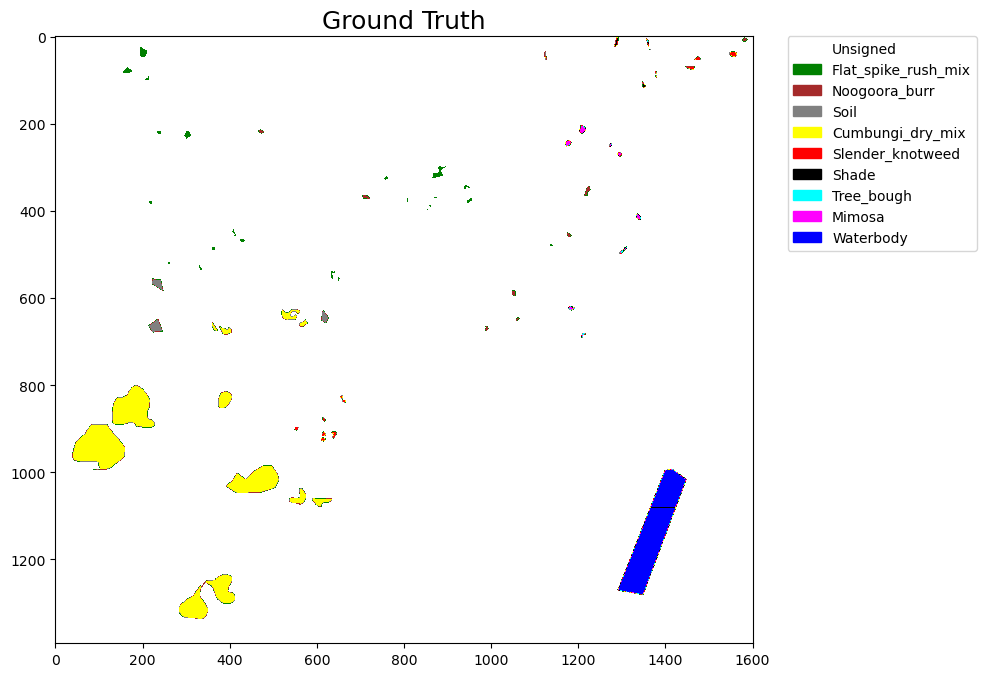

In [19]:
# Display ground truth image
values = np.unique(imlabel.ravel())
fig, ax= plt.subplots( figsize=(9, 9))
im10=plt.imshow(imlabel,cmap=ListedColormap(['white','olivedrab','magenta', 'yellow','darkorange','forestgreen', 'dimgrey','snow',
                                                'aqua','greenyellow', 'lightgrey','lawngreen', 'palevioletred','dodgerblue','lavender'])) 
patches = [ mpatches.Patch(color=colors[0], label="Unsigned"),
            mpatches.Patch(color=colors[1], label=class_labels[0]),
            mpatches.Patch(color=colors[2], label=class_labels[1]),
            mpatches.Patch(color=colors[3], label=class_labels[2]),
            mpatches.Patch(color=colors[4], label=class_labels[3]),
            mpatches.Patch(color=colors[5], label=class_labels[4]),
            mpatches.Patch(color=colors[6], label=class_labels[5]),
            mpatches.Patch(color=colors[7], label=class_labels[6]),
            mpatches.Patch(color=colors[8], label=class_labels[7]),
            mpatches.Patch(color=colors[9], label=class_labels[8]),
            mpatches.Patch(color=colors[10], label=class_labels[9]),
            mpatches.Patch(color=colors[11], label=class_labels[10]),
            mpatches.Patch(color=colors[12], label=class_labels[11]),
            mpatches.Patch(color=colors[13], label=class_labels[12]),
            mpatches.Patch(color=colors[14], label=class_labels[13])
               ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
ax.set_title('Ground Truth',fontsize=18) 
plt.show()

In [17]:
# Load model from pickle file (optional)
model_pkl = "Gwydir_vegetation_classifier_svmmodel.pkl" 
with open(model_pkl, 'rb') as file:
    model = pickle.load(file)

In [ ]:
# Read entire image
# read image file
im2 = imread('\MDBA_Gwydir\classification\python\inputs\multi\Gwydir_0517_mosaic_area1.tif') #change root #Gwydir_0517_sub1_larger.tif

# plot RGB image
ep.plot_rgb(im2,
            rgb=[5,3,1],
            title="RGB Composite of sample image\n Linear Stretch Applied",
            stretch=True,
            str_clip=4)
plt.show()

# transpose image
im3 = np.transpose(im2, (1,2,0))

In [18]:
# Train the entire image with the model
imall = np.reshape(im3,(im3.shape[0]*im3.shape[1],10))
image_pred0 = model0.predict(imall)
image_pred = np.reshape(image_pred0,(im3.shape[0],im3.shape[1]))

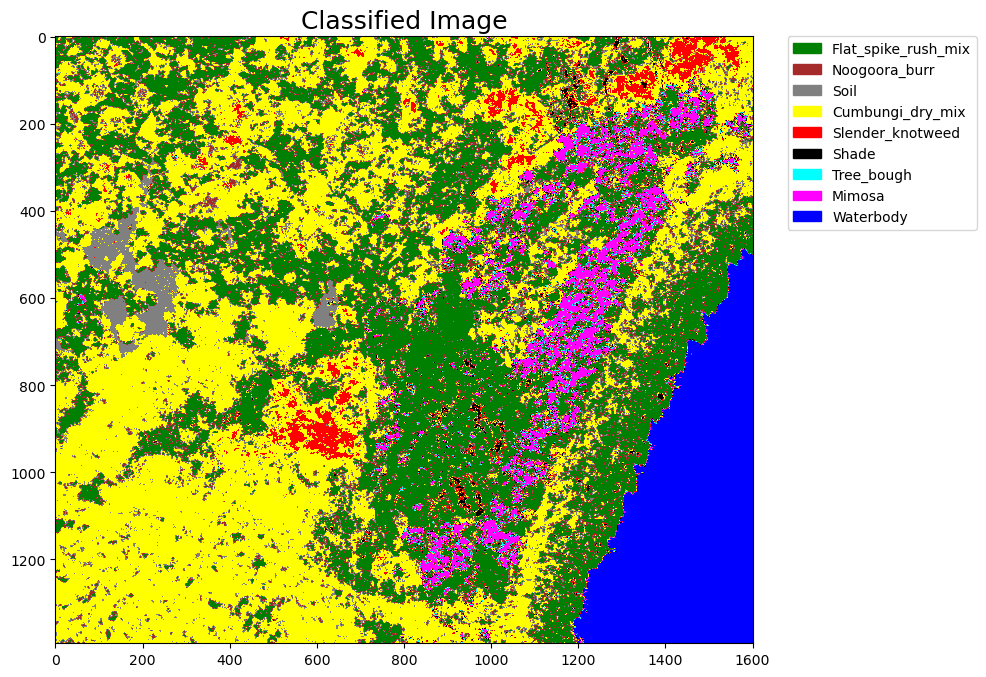

In [20]:
# Display classified image
values = np.unique(image_pred.ravel())
fig, ax= plt.subplots( figsize=(9, 9))
im10=plt.imshow(image_pred,cmap=ListedColormap(['olivedrab','magenta', 'yellow','darkorange','forestgreen', 'dimgrey','snow',
                                                'aqua','greenyellow', 'lightgrey','lawngreen', 'palevioletred','dodgerblue','lavender']))
colors = [ im10.cmap(im10.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[0], label=class_labels[0]),
            mpatches.Patch(color=colors[1], label=class_labels[1]),
            mpatches.Patch(color=colors[2], label=class_labels[2]),
            mpatches.Patch(color=colors[3], label=class_labels[3]),
            mpatches.Patch(color=colors[4], label=class_labels[4]),
            mpatches.Patch(color=colors[5], label=class_labels[5]),
            mpatches.Patch(color=colors[6], label=class_labels[6]),
            mpatches.Patch(color=colors[7], label=class_labels[7]),
            mpatches.Patch(color=colors[8], label=class_labels[8]),
            mpatches.Patch(color=colors[9], label=class_labels[9]),
            mpatches.Patch(color=colors[10], label=class_labels[10]),
            mpatches.Patch(color=colors[11], label=class_labels[11]),
            mpatches.Patch(color=colors[12], label=class_labels[12]),
            mpatches.Patch(color=colors[13], label=class_labels[13])
            ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
ax.set_title('Classified Image',fontsize=18) 
plt.show()